In [1]:
import warnings
import os
# Suppress FutureWarning messages
warnings.simplefilter(action='ignore', category=FutureWarning)
%load_ext autoreload
%autoreload 2
os.chdir('..')
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="4"
os.getcwd()

'/Users/prateekgarg/tiny-discrete-diffusion'

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import utils

In [3]:
import torchvision
import torchvision.transforms as transforms

N_TOKENS = 5
RESOLUTION = 14 # 10x10 images
if os.path.exists(f'data/processed/MNIST/train_images_{N_TOKENS}_{RESOLUTION}x{RESOLUTION}.pt') == False:
    transform = transforms.Compose([transforms.ToTensor(), 
                                    transforms.Resize((RESOLUTION, RESOLUTION))])
    trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    MAX_BATCH_SIZE = max(len(trainset), len(testset))
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=MAX_BATCH_SIZE, shuffle=False)
    testloader = torch.utils.data.DataLoader(testset, batch_size=MAX_BATCH_SIZE, shuffle=False)

    for i, data in enumerate(trainloader, 0):
        train_images, train_labels = data
        break

    for i, data in enumerate(testloader, 0):
        test_images, test_labels = data
        break

    data_min = train_images.min()
    data_max = train_images.max()

    train_images, token_vals = utils.discretize_data( train_images, N_TOKENS, data_max=data_max, data_min=data_min)
    test_images, token_vals = utils.discretize_data( test_images, N_TOKENS, data_max=data_max, data_min=data_min)
    os.makedirs('data/processed/MNIST', exist_ok=True)
    torch.save(train_images, f'data/processed/MNIST/train_images_{N_TOKENS}_{RESOLUTION}x{RESOLUTION}.pt')
    torch.save(train_labels, 'data/processed/MNIST/train_labels.pt')
    torch.save(test_images, f'data/processed/MNIST/test_images_{N_TOKENS}_{RESOLUTION}x{RESOLUTION}.pt')
    torch.save(test_labels, 'data/processed/MNIST/test_labels.pt')
    torch.save(token_vals, f'data/processed/MNIST/token_vals_{N_TOKENS}_{RESOLUTION}x{RESOLUTION}.pt')

else:
    train_images = torch.load(f'data/processed/MNIST/train_images_{N_TOKENS}_{RESOLUTION}x{RESOLUTION}.pt')
    train_labels = torch.load('data/processed/MNIST/train_labels.pt')
    test_images = torch.load(f'data/processed/MNIST/test_images_{N_TOKENS}_{RESOLUTION}x{RESOLUTION}.pt')
    test_labels = torch.load('data/processed/MNIST/test_labels.pt')
    token_vals = torch.load(f'data/processed/MNIST/token_vals_{N_TOKENS}_{RESOLUTION}x{RESOLUTION}.pt')

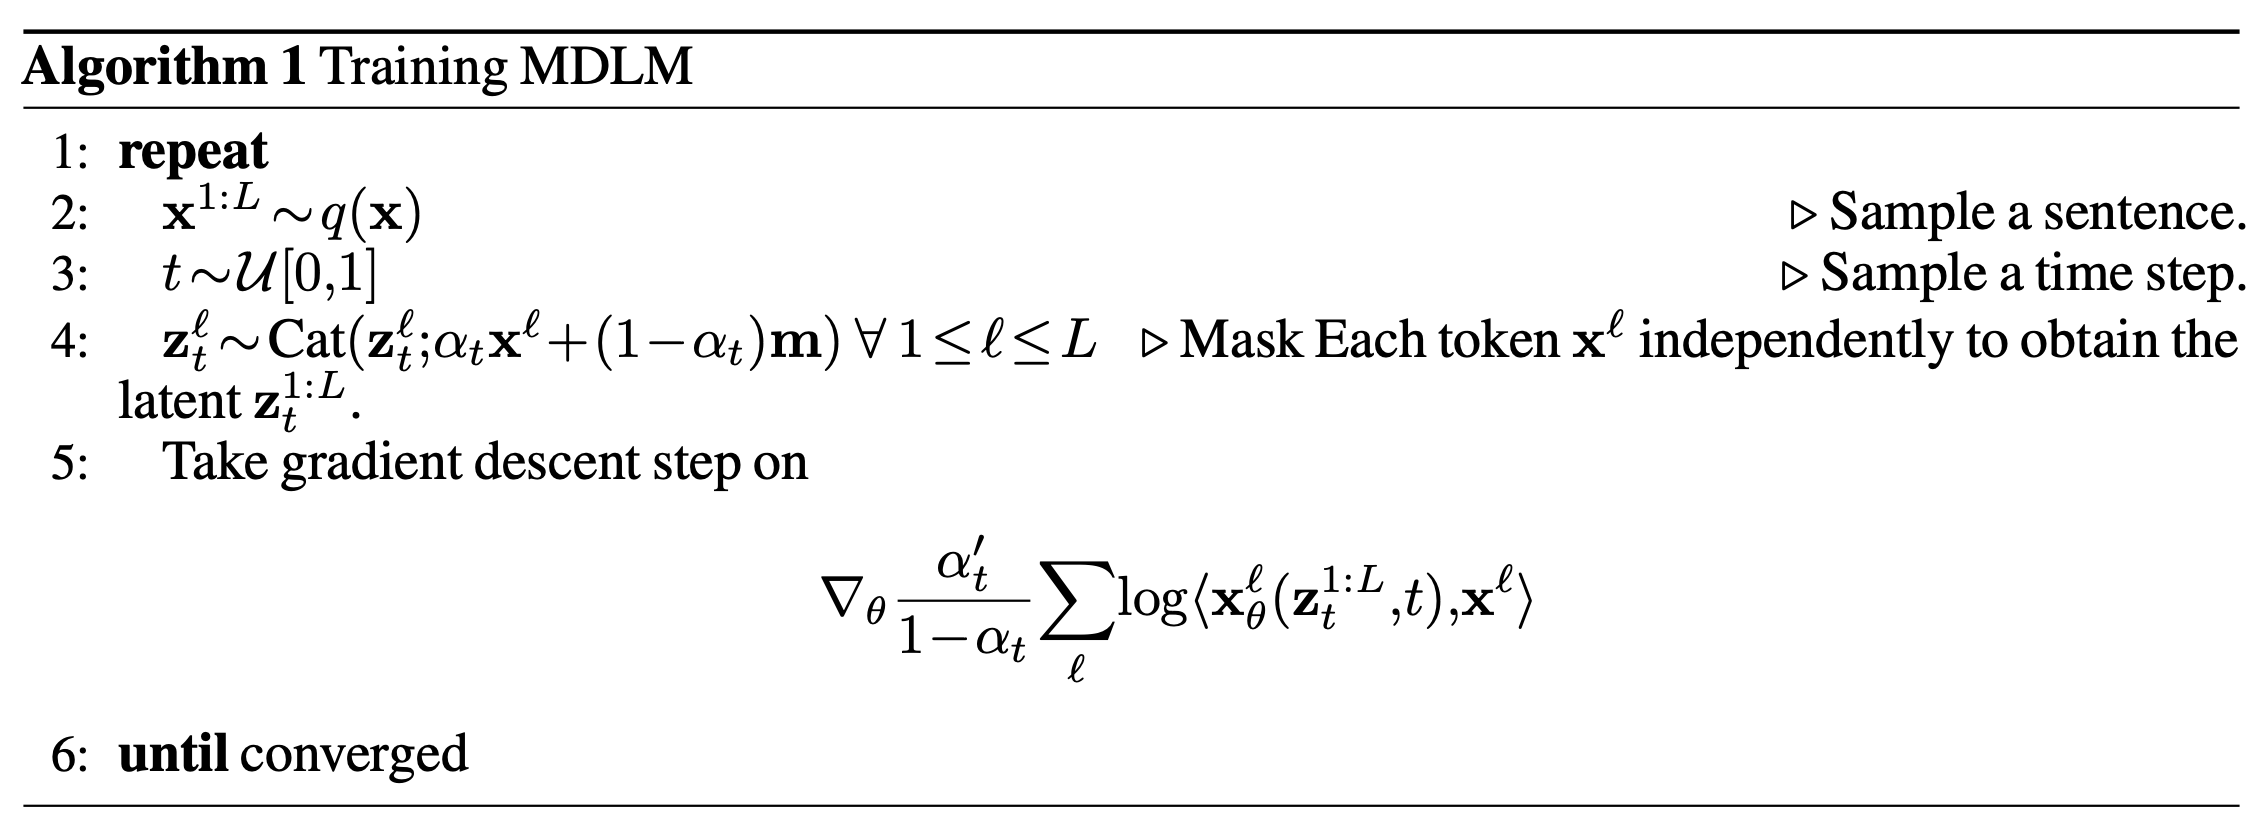

In [5]:
# tokenized_images = train_images[:5]
# for t in torch.linspace(0,1,15):
#     masks = torch.rand_like(tokenized_images, dtype=torch.float) < 1 - masking_sch.get_alpha(t)
#     masked_tokenized_images = torch.where(masks, torch.tensor(N_TOKENS, device=tokenized_images.device), tokenized_images)

#     # detokenize
#     gray_values = token_vals[tokenized_images]
#     colored_images = gray_values.repeat(1,3, 1, 1)

#     utils.viz_masked_images(colored_images, masks, nrow=5)

In [6]:
train_tokens = train_images.reshape(len(train_images), -1).long()[:1024]
test_tokens = test_images.reshape(len(test_images), -1).long()[:128]
# train_tokens.reshape(len(train_tokens), 1,RESOLUTION, RESOLUTION) to recover
train_tokens.shape, test_tokens.shape

(torch.Size([1024, 196]), torch.Size([128, 196]))

In [7]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math

class TimeEncoding(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.freqs = nn.Parameter(torch.exp(torch.linspace(0, 6, embed_dim // 2))) 

    def forward(self, t):
        t = t.unsqueeze(-1) * self.freqs  
        return torch.cat([t.sin(), t.cos()], dim=-1)  
    
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pe", pe)

    def forward(self, x):
        # Batch First, unnecassarily convoluted but works as expected
        x = x + self.pe[: x.size(1), :].view(1, x.size(1), -1)
        return self.dropout(x)

class Unmasker(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, num_heads=4, num_layers=4, hidden_dim=256, dropout=0.1, n_dim = RESOLUTION**2):
        super().__init__()
        self.tim_embed = TimeEncoding(embed_dim)
        self.tok_embed = nn.Embedding(vocab_size, embed_dim)
        self.pos_embed = PositionalEncoding(embed_dim, dropout=dropout, max_len=n_dim)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=hidden_dim, dropout=dropout, batch_first=True)
        self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.output_layer = nn.Linear(embed_dim, vocab_size)

    def forward(self, x, t):
        x = self.pos_embed(self.tok_embed(x)) + self.tim_embed(t)
        x = self.encoder(x)
        return self.output_layer(x)

In [8]:
class MaskingScheduler:
    def __init__(self, mode = "linear"):
        self.mode = mode
        self.eps = 1e-6
        self.init_linear_scheduler()
    def init_linear_scheduler(self):
        self.alpha = lambda t : 1 - t
        self.ce_weight = lambda t : -1/(t + self.eps) 

    @torch.no_grad()
    def get_alpha(self, t):
        return self.alpha(t)
    
    @torch.no_grad()
    def get_ce_weight(self, t):
        return self.ce_weight(t)

In [9]:
model = Unmasker(N_TOKENS + 1, embed_dim=32, num_heads=8, num_layers=8, hidden_dim=16, dropout=0.3, n_dim = RESOLUTION**2)
optimizer = optim.Adam(model.parameters(), lr=1e-6)
masking_sch = MaskingScheduler()
loss_fn = nn.CrossEntropyLoss()
N_EPOCHS = 1000
BATCH_SIZE = 512
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_tokens), batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_tokens), batch_size=BATCH_SIZE, shuffle=False)
losses = {
    "train": [],
    "test" : []
}

for epoch in range(N_EPOCHS):
    model.train()
    epoch_train_loss = 0 
    batch_count = 0
    for i, (tokens,) in enumerate(train_loader):
        time_steps = torch.rand(tokens.shape[0], dtype=torch.float).reshape(-1,1).repeat(1, tokens.shape[1]).to(tokens.device)
        alpha_t = masking_sch.get_alpha(time_steps)
        ce_weight_t = masking_sch.get_ce_weight(time_steps)
        masks = torch.rand_like(tokens, dtype=torch.float) < 1 - alpha_t
        masked_tokens = torch.where(masks, torch.tensor(N_TOKENS, device=tokens.device), tokens) 
        pred = model(masked_tokens, time_steps)

        logprob = torch.log_softmax(pred, dim=-1)
        loss = (logprob[torch.arange(logprob.shape[0]).reshape(-1,1),torch.arange(logprob.shape[1]), tokens] * ce_weight_t * masks).sum(dim=-1).mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item() * len(tokens)
        batch_count += len(tokens)

        # if i % 100 == 0:
        # print(f"Epoch {epoch}, Batch {i}, Loss {loss.item()}")
    losses["train"].append(epoch_train_loss / batch_count)
    print(f"Epoch {epoch}, Train Loss {losses['train'][-1] :.03f}")

    epoch_test_loss = 0
    test_batch_count = 0

    model.eval()
    with torch.no_grad():
        for i, (tokens,) in enumerate(test_loader):
            time_steps = torch.rand(tokens.shape[0], dtype=torch.float).reshape(-1,1).repeat(1, tokens.shape[1]).to(tokens.device)
            alpha_t = masking_sch.get_alpha(time_steps)
            ce_weight_t = masking_sch.get_ce_weight(time_steps)
            masks = torch.rand_like(tokens, dtype=torch.float) < alpha_t
            masked_tokens = torch.where(masks, torch.tensor(N_TOKENS, device=tokens.device), tokens) 
            pred = model(masked_tokens, time_steps)

            logprob = torch.log_softmax(pred, dim=-1)
            loss = (logprob[torch.arange(logprob.shape[0]).reshape(-1,1),torch.arange(logprob.shape[1]), tokens] * ce_weight_t).sum(dim=-1).mean()
            epoch_test_loss += loss.item() * len(tokens)
            test_batch_count += len(tokens)
    losses["test"].append(epoch_test_loss / test_batch_count)
    print(f"Epoch {epoch}, Test  Loss {losses['test'][-1]:.03f}")


Epoch 0, Train Loss 405.602
Epoch 0, Test  Loss 5902.855
Epoch 1, Train Loss 403.906
Epoch 1, Test  Loss 2997.193
Epoch 2, Train Loss 403.715
Epoch 2, Test  Loss 2404.024
Epoch 3, Train Loss 399.009
Epoch 3, Test  Loss 3769.641
Epoch 4, Train Loss 403.699
Epoch 4, Test  Loss 2854.043
Epoch 5, Train Loss 407.217
Epoch 5, Test  Loss 3939.760
Epoch 6, Train Loss 400.026
Epoch 6, Test  Loss 2553.858
Epoch 7, Train Loss 402.324
Epoch 7, Test  Loss 1997.109
Epoch 8, Train Loss 400.152
Epoch 8, Test  Loss 1652.940
Epoch 9, Train Loss 407.800
Epoch 9, Test  Loss 1969.127
Epoch 10, Train Loss 402.175
Epoch 10, Test  Loss 19886.379
Epoch 11, Train Loss 401.041
Epoch 11, Test  Loss 3644.914
Epoch 12, Train Loss 399.388
Epoch 12, Test  Loss 3344.241
Epoch 13, Train Loss 400.843
Epoch 13, Test  Loss 1974.333
Epoch 14, Train Loss 400.640
Epoch 14, Test  Loss 7585.354
Epoch 15, Train Loss 403.610
Epoch 15, Test  Loss 2774.345
Epoch 16, Train Loss 401.719
Epoch 16, Test  Loss 1754.958
Epoch 17, Train 

KeyboardInterrupt: 

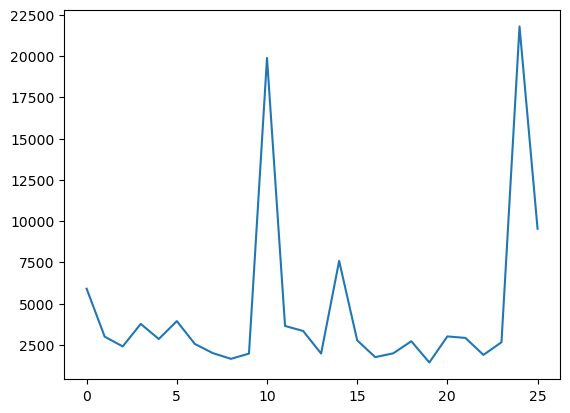

In [13]:
# plt.plot(losses["train"], label="Train")
plt.plot(losses["test"][:-1], label="Test")